In [3]:
!pip install pandas
!pip install numpy
!pip install statsmodels
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [20]:
# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# main
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('display.max_columns', 500)

In [21]:
# reading data
data = pd.read_csv('./data.csv')
data

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,THROW_SIDE_KEY,PITCH_TYPE_TRACKED_KEY,EVENT_RESULT_KEY,PITCH_RESULT_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,668881,R,FB,field_out,InPlay,14.54220,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,668881,R,FB,NaN,BallCalled,14.25380,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,668881,R,SL,single,InPlay,5.56877,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,668881,R,SL,NaN,FoulBall,4.80541,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,668881,R,SL,NaN,BallCalled,4.13239,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,9,4,2,2,1,0,1,0,0,643361,R,FB,NaN,StrikeCalled,15.72580,-8.54239,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,0.750023,3.40322
9885,28642,9,4,3,2,1,1,1,0,0,643361,R,CF,NaN,BallCalled,10.86980,0.60670,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,0.872825,3.17087
9886,22664,9,4,4,2,2,1,1,0,0,643361,R,FB,NaN,FoulBall,14.10840,-10.84110,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,-0.988207,2.56097
9887,22665,9,4,5,2,2,2,1,0,0,643361,R,CH,double,InPlay,10.49140,-13.44000,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,-0.278290,2.14642


Need to standardize the Pitcher Handedness to remove THROW_SIDE_KEY from context.  
###### Attributes affected by handedness are,
- HORIZONTAL_BREAK
- RELEASE_SIDE
- HORIZONTAL_APPROACH_ANGLE

To handle this I will flip the sign for the above attributes for Left handed pitchers.

In [22]:
data['THROW_SIDE_KEY'].value_counts()

R    7268
L    2621
Name: THROW_SIDE_KEY, dtype: int64

In [23]:
data['HORIZONTAL_BREAK'] = data.apply(lambda x: -x['HORIZONTAL_BREAK'] if x['THROW_SIDE_KEY'] == 'L' else x['HORIZONTAL_BREAK'], axis=1)
data['RELEASE_SIDE'] = data.apply(lambda x: -x['RELEASE_SIDE'] if x['THROW_SIDE_KEY'] == 'L' else x['RELEASE_SIDE'], axis=1)
data['HORIZONTAL_APPROACH_ANGLE'] = data.apply(lambda x: -x['HORIZONTAL_APPROACH_ANGLE'] if x['THROW_SIDE_KEY'] == 'L' else x['HORIZONTAL_APPROACH_ANGLE'], axis=1)
data = data.drop(columns="THROW_SIDE_KEY")

In [24]:
data.isna().sum()

PID                             0
INNING_KEY                      0
BATTER_IN_INNING_KEY            0
PITCH_NUMBER                    0
OUT_KEY                         0
BALLS                           0
STRIKES                         0
IS_RUNNER_ON_1B                 0
IS_RUNNER_ON_2B                 0
IS_RUNNER_ON_3B                 0
PITCHER_KEY                     0
PITCH_TYPE_TRACKED_KEY          0
EVENT_RESULT_KEY             7258
PITCH_RESULT_KEY                0
INDUCED_VERTICAL_BREAK          0
HORIZONTAL_BREAK                0
SPIN_RATE_ABSOLUTE              0
RELEASE_SPEED                   0
RELEASE_SIDE                    0
RELEASE_HEIGHT                  0
RELEASE_EXTENSION               0
HORIZONTAL_APPROACH_ANGLE       0
VERTICAL_APPROACH_ANGLE         0
PLATE_X                         0
PLATE_Z                         0
dtype: int64

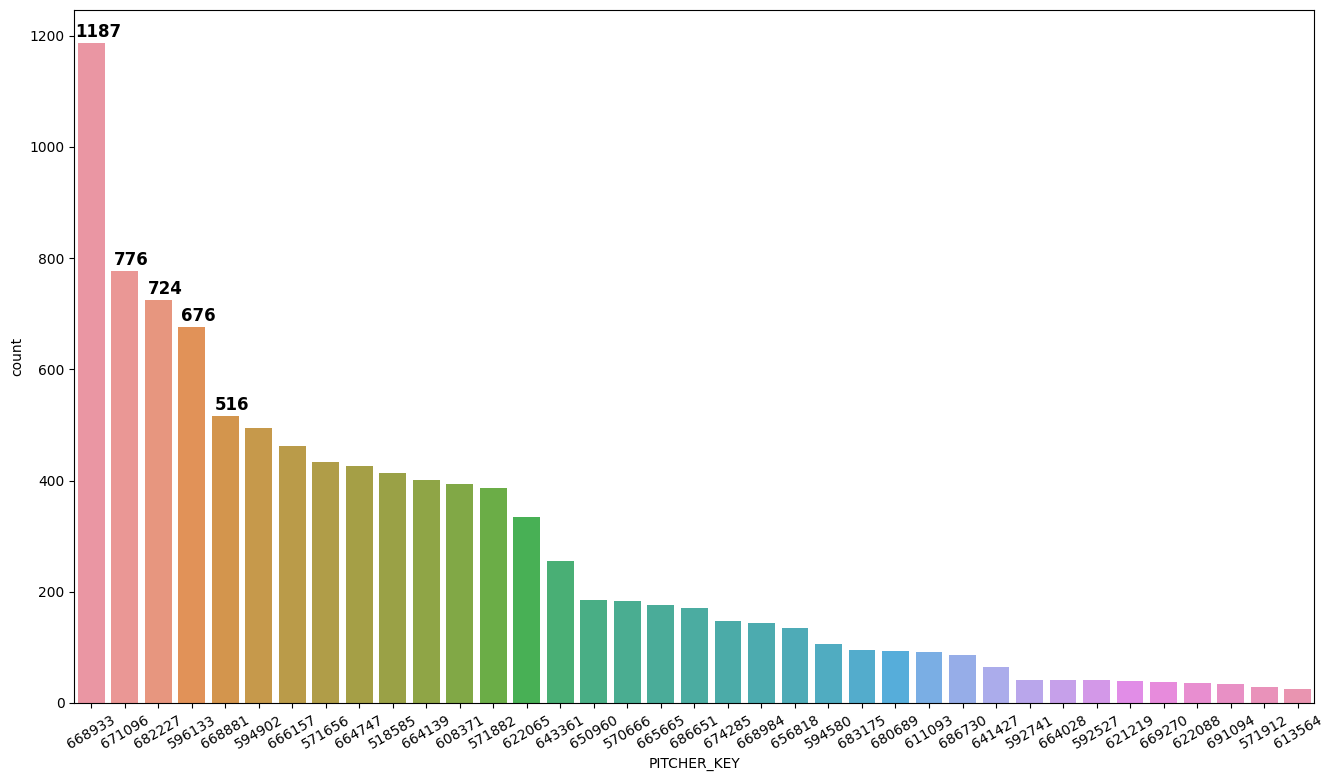

In [25]:
# plot to show different number of pitchers

fig_pitcher, ax_pitcher = plt.subplots(figsize=(16,9))
sns.countplot(data, x="PITCHER_KEY", ax=ax_pitcher, order=data['PITCHER_KEY'].value_counts().index)
plt.xticks(rotation=30)
for index, value in enumerate(data['PITCHER_KEY'].value_counts()[0:5]):
    label = '{}'.format(value)
    ax_pitcher.annotate(label,
                xy=(index+0.2, value+20),
                ha='center',
                va='center',
                fontweight='bold',
                size=12)
plt.show()

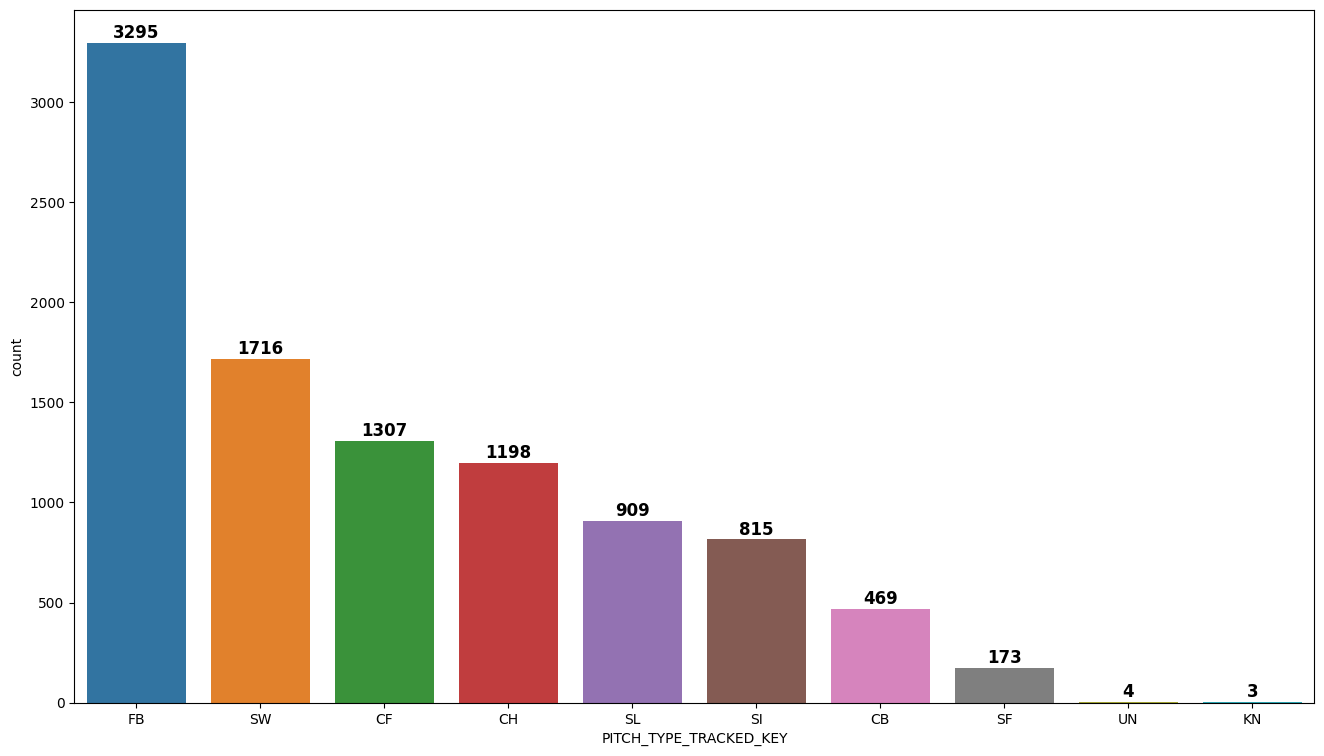

In [26]:
# plot to show different number of pitches

fig_pitches, ax_pitches = plt.subplots(figsize=(16,9))
sns.countplot(data, x="PITCH_TYPE_TRACKED_KEY", ax=ax_pitches, order=data['PITCH_TYPE_TRACKED_KEY'].value_counts().index)
for index, value in enumerate(data['PITCH_TYPE_TRACKED_KEY'].value_counts()):
    label = '{}'.format(value)
    ax_pitches.annotate(label,
                xy=(index, value+50),
                ha='center',
                va='center',
                fontweight='bold',
                size=12)
plt.show()

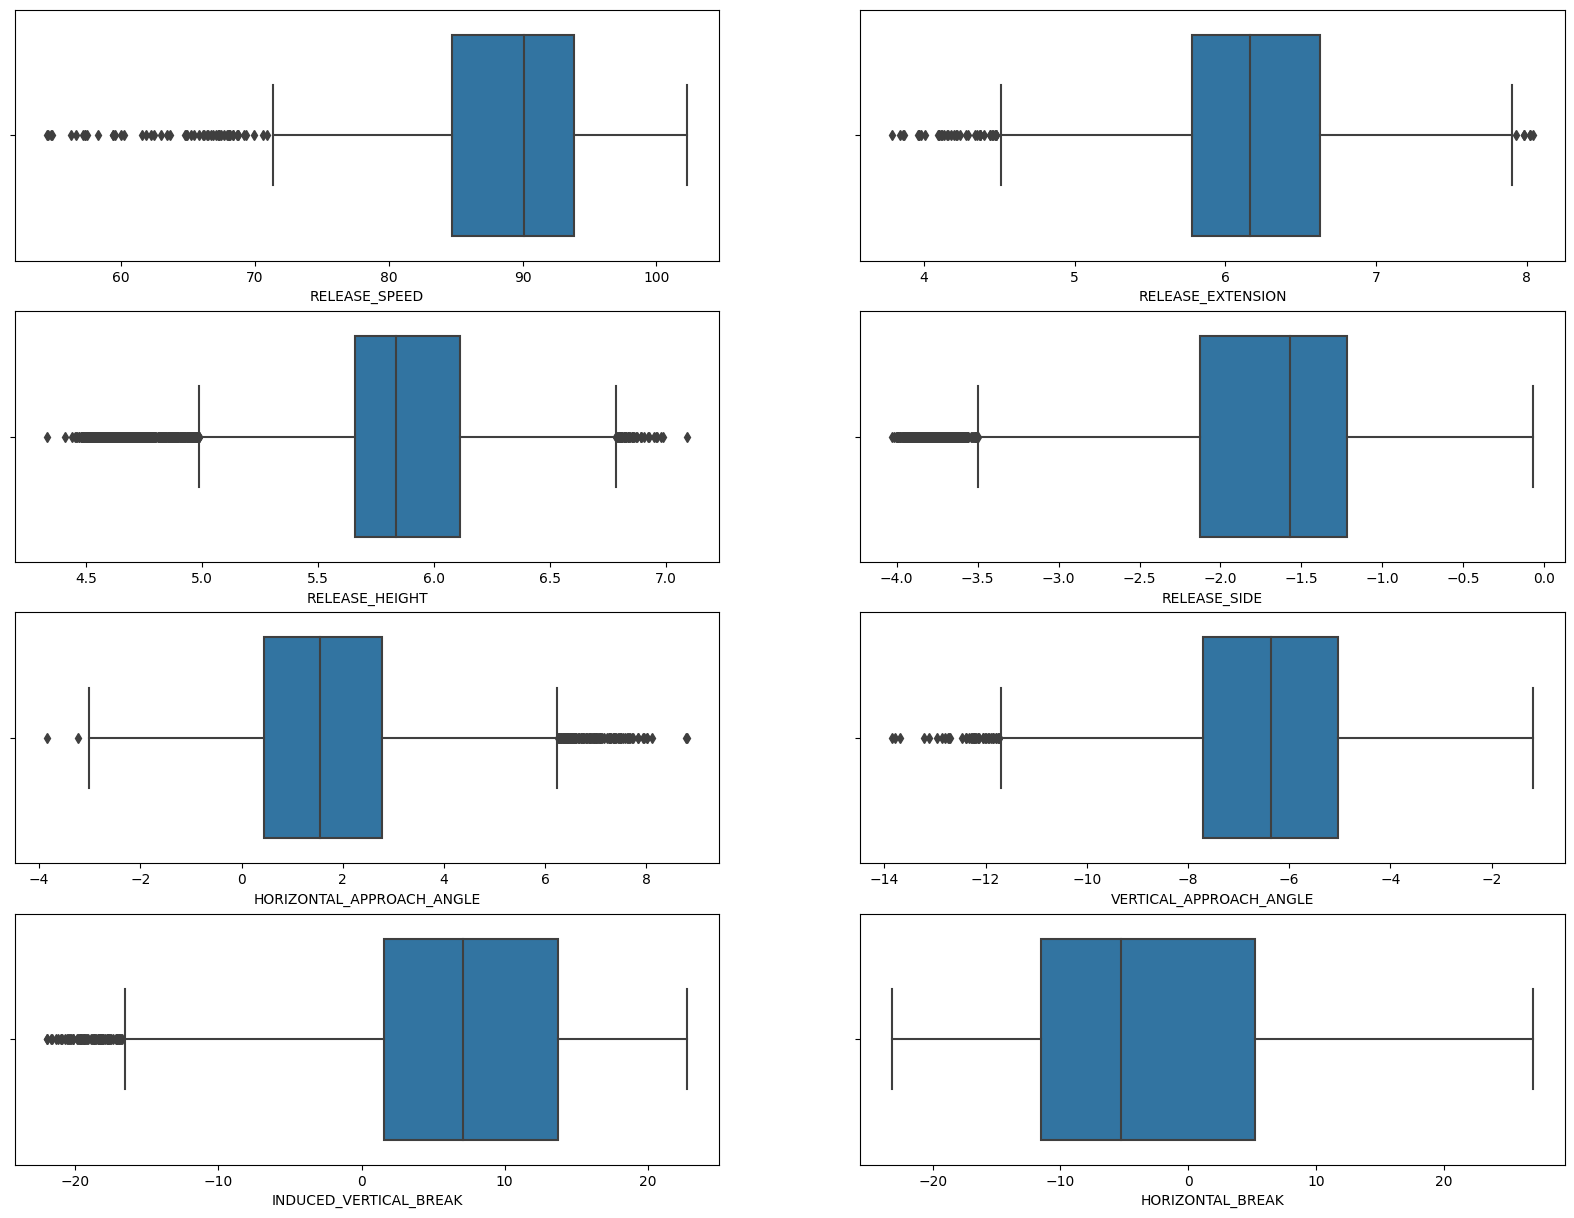

In [27]:
# box plot to look for outliers, followed by describe method

fig_pchar, ax_pchar = plt.subplots(4,2,figsize=(20,15))
sns.boxplot(data, x="RELEASE_SPEED", ax=ax_pchar[0][0])
sns.boxplot(data, x="RELEASE_EXTENSION", ax=ax_pchar[0][1])
sns.boxplot(data, x="RELEASE_HEIGHT", ax=ax_pchar[1][0])
sns.boxplot(data, x="RELEASE_SIDE", ax=ax_pchar[1][1])
sns.boxplot(data, x="HORIZONTAL_APPROACH_ANGLE", ax=ax_pchar[2][0])
sns.boxplot(data, x="VERTICAL_APPROACH_ANGLE", ax=ax_pchar[2][1])
sns.boxplot(data, x="INDUCED_VERTICAL_BREAK", ax=ax_pchar[3][0])
sns.boxplot(data, x="HORIZONTAL_BREAK", ax=ax_pchar[3][1])
plt.show()

In [28]:
data.describe()

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,PITCHER_KEY,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
count,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000,9889.000000
mean,12609.406007,5.007786,2.935079,2.878653,0.997674,0.882293,0.874810,0.309839,0.174638,0.102033,637412.410254,6.937282,-2.766825,2293.930972,89.144199,-1.724224,5.825911,6.226203,1.697140,-6.415098,0.072584,2.338810
std,7802.242707,2.660815,1.741784,1.714279,0.822356,0.965159,0.822483,0.462451,0.379677,0.302706,44958.635446,7.749274,10.821963,377.813504,5.925928,0.753131,0.460130,0.561980,1.692177,1.831539,0.822927,0.975443
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,518585.000000,-21.982201,-23.168800,524.210999,54.441101,-4.026390,4.330060,3.790000,-3.847480,-13.842500,-3.588650,-1.892670
25%,6004.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,596133.000000,1.593640,-11.542100,2131.350098,84.752502,-2.128630,5.659290,5.780000,0.452647,-7.700000,-0.479877,1.689210
50%,12590.000000,5.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,664747.000000,7.065330,-5.278490,2322.459961,90.093803,-1.572290,5.835330,6.160000,1.542860,-6.365400,0.073093,2.340190
75%,19511.000000,7.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,668933.000000,13.751000,5.218290,2502.469971,93.820900,-1.218050,6.109050,6.630000,2.771020,-5.029050,0.621404,3.001330
max,28755.000000,11.000000,14.000000,14.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,691094.000000,22.767300,26.991199,3314.679932,102.327003,-0.071233,7.090960,8.040000,8.813830,-1.185400,3.983160,6.079330


Just keeping pitch characteristics (fixed effects) that may affect Induced Vertical Break and Horizontal Break. For random effect, we can take the Pitcher ID and the Pitch Type in context.

In [29]:
data = data.loc[:,['PID', 'PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY', 'SPIN_RATE_ABSOLUTE',
       'RELEASE_SPEED', 'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE','INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK']]
data

,PID,PITCHER_KEY,PITCH_TYPE_TRACKED_KEY,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK
0,197,668881,FB,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,14.54220,-12.36030
1,348,668881,FB,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,14.25380,-10.95030
2,1072,668881,SL,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,5.56877,4.35335
3,420,668881,SL,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,4.80541,4.27254
4,198,668881,SL,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,4.13239,1.62418
...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,643361,FB,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,15.72580,-8.54239
9885,28642,643361,CF,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,10.86980,0.60670
9886,22664,643361,FB,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,14.10840,-10.84110
9887,22665,643361,CH,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,10.49140,-13.44000


In [30]:
display(data.corr())
def high_corr_pairs(df, threshold=0.8):
    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    pairs = []
    for column in to_drop:
        above_threshold_vars = upper.index[upper[column] > threshold].tolist()
        for atv in above_threshold_vars:
            pairs.append((column, atv))

    return pairs

high_corr_pairs(data, threshold=0.6)

,PID,PITCHER_KEY,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,INDUCED_VERTICAL_BREAK,HORIZONTAL_BREAK
PID,1.000000,0.112200,0.012889,0.027363,0.221353,-0.003156,0.038060,-0.077817,0.049082,0.012763,0.067574
PITCHER_KEY,0.112200,1.000000,0.255386,0.163787,-0.236525,0.032677,0.036600,0.133409,0.048882,-0.011640,0.051085
SPIN_RATE_ABSOLUTE,0.012889,0.255386,1.000000,0.078542,-0.108107,-0.032595,-0.138292,0.521643,-0.031699,-0.155577,0.574143
RELEASE_SPEED,0.027363,0.163787,0.078542,1.000000,0.044849,0.059014,0.041314,-0.350263,0.685221,0.646535,-0.448138
RELEASE_SIDE,0.221353,-0.236525,-0.108107,0.044849,1.000000,0.454214,-0.166127,-0.383873,-0.046152,0.082818,0.111645
RELEASE_HEIGHT,-0.003156,0.032677,-0.032595,0.059014,0.454214,1.000000,-0.512797,-0.140316,-0.230833,-0.005648,0.102465
RELEASE_EXTENSION,0.038060,0.036600,-0.138292,0.041314,-0.166127,-0.512797,1.000000,0.026056,0.194315,0.126053,-0.105842
HORIZONTAL_APPROACH_ANGLE,-0.077817,0.133409,0.521643,-0.350263,-0.383873,-0.140316,0.026056,1.000000,-0.390895,-0.418088,0.732362
VERTICAL_APPROACH_ANGLE,0.049082,0.048882,-0.031699,0.685221,-0.046152,-0.230833,0.194315,-0.390895,1.000000,0.781252,-0.427216
INDUCED_VERTICAL_BREAK,0.012763,-0.011640,-0.155577,0.646535,0.082818,-0.005648,0.126053,-0.418088,0.781252,1.000000,-0.518750


[('VERTICAL_APPROACH_ANGLE', 'RELEASE_SPEED'),
 ('INDUCED_VERTICAL_BREAK', 'RELEASE_SPEED'),
 ('INDUCED_VERTICAL_BREAK', 'VERTICAL_APPROACH_ANGLE'),
 ('HORIZONTAL_BREAK', 'HORIZONTAL_APPROACH_ANGLE')]

In [31]:
# Class fitting the Mixed LM for Induced Vertical Break and Horizontal Break each
class Model:
    def __init__(self, fit_param, data):
        self.data = data
        self.fit_param = fit_param
        
    def scale_data(self, dummy):
        scaler = StandardScaler()
        scaled_data = pd.DataFrame(scaler.fit_transform(dummy), columns=self.data.iloc[:,3:].columns)
        self.data = pd.concat([self.data.iloc[:,:3],scaled_data], axis=1)
        
    def build_model(self, *group_col):
        if len(group_col)==1:
            self.model = smf.mixedlm(self.fit_param, self.data, groups = self.data[group_col[0]]).fit()
        elif len(group_col)==2:
            if self.data[group_col[0]].dtypes == object or self.data[group_col[1]].dtypes == object:
                self.data[group_col[0]+'_'+group_col[1]] = str(self.data[group_col[0]]) + '_' + str(self.data[group_col[1]])
            self.model = smf.mixedlm(self.fit_param, self.data, groups = self.data[group_col[0]+'_'+group_col[1]]).fit()
        
    def get_residuals(self):
        self.data['residuals'] = self.model.resid
        return self.data['residuals']
    
    def compute_prob(self):
        mean_resid = np.mean(self.data['residuals'])
        std_resid = np.std(self.data['residuals'])
        
        self.data['z_score'] = (self.data['residuals'] - mean_resid) / std_resid
        self.data['prob_affected'] = 1 - self.data['z_score'].apply(norm.cdf)
        
        return self.data[['PID','prob_affected']]
    
    def plot_resid(self):
        fig, axs = plt.subplots(2, figsize = (16,9))
        sns.kdeplot(self.model.resid, fill=True, common_norm=True, ax=axs[0])
        sm.qqplot(self.model.resid, dist=norm, line='s', ax=axs[1])

0       0.613263
1       0.067137
2      -0.053160
3      -0.084933
4      -0.643762
          ...   
9884    0.184403
9885   -0.031537
9886    0.426825
9887    0.526400
9888    0.734537
Name: residuals, Length: 9889, dtype: float64


,PID,prob_affected
0,197,0.146083
1,348,0.454096
2,1072,0.536377
3,420,0.557994
4,198,0.865587
...,...,...
9884,22663,0.375720
9885,28642,0.521600
9886,22664,0.231735
9887,22665,0.182950


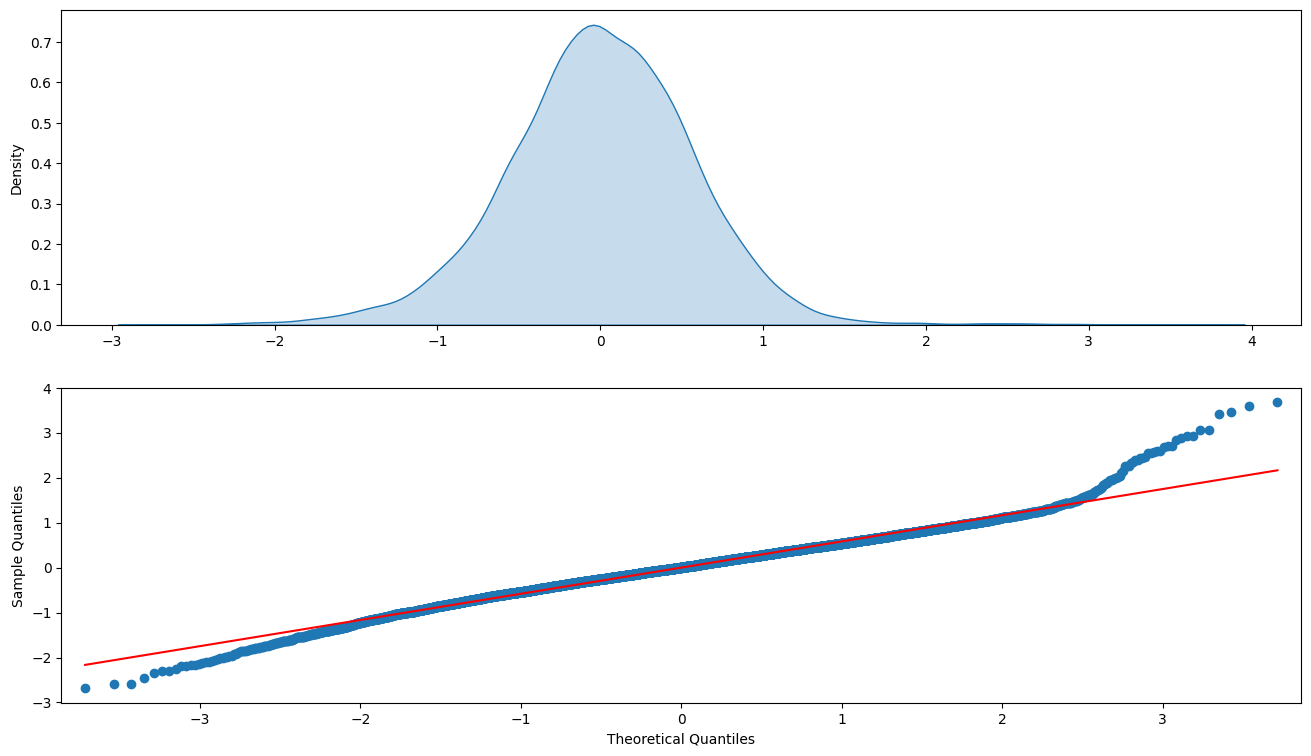

In [32]:
vertical_break = Model("INDUCED_VERTICAL_BREAK ~ SPIN_RATE_ABSOLUTE + RELEASE_SIDE + RELEASE_EXTENSION + HORIZONTAL_APPROACH_ANGLE + VERTICAL_APPROACH_ANGLE", data)
vertical_break.scale_data(data.iloc[:,3:])
#vertical_break.build_model("PITCHER_KEY")
vertical_break.build_model("PITCHER_KEY","PITCH_TYPE_TRACKED_KEY")
print(vertical_break.get_residuals())
vertical_break.plot_resid()
prob_vertical = vertical_break.compute_prob()
display(prob_vertical)

0       0.029961
1       0.633429
2       0.575012
3       0.298917
4       0.515754
          ...   
9884   -0.328956
9885    0.029714
9886    0.275615
9887   -0.352898
9888   -0.117926
Name: residuals, Length: 9889, dtype: float64


,PID,prob_affected
0,197,0.472838
1,348,0.074853
2,1072,0.095485
3,420,0.248313
4,198,0.120408
...,...,...
9884,22663,0.772807
9885,28642,0.473061
9886,22664,0.265391
9887,22665,0.788889


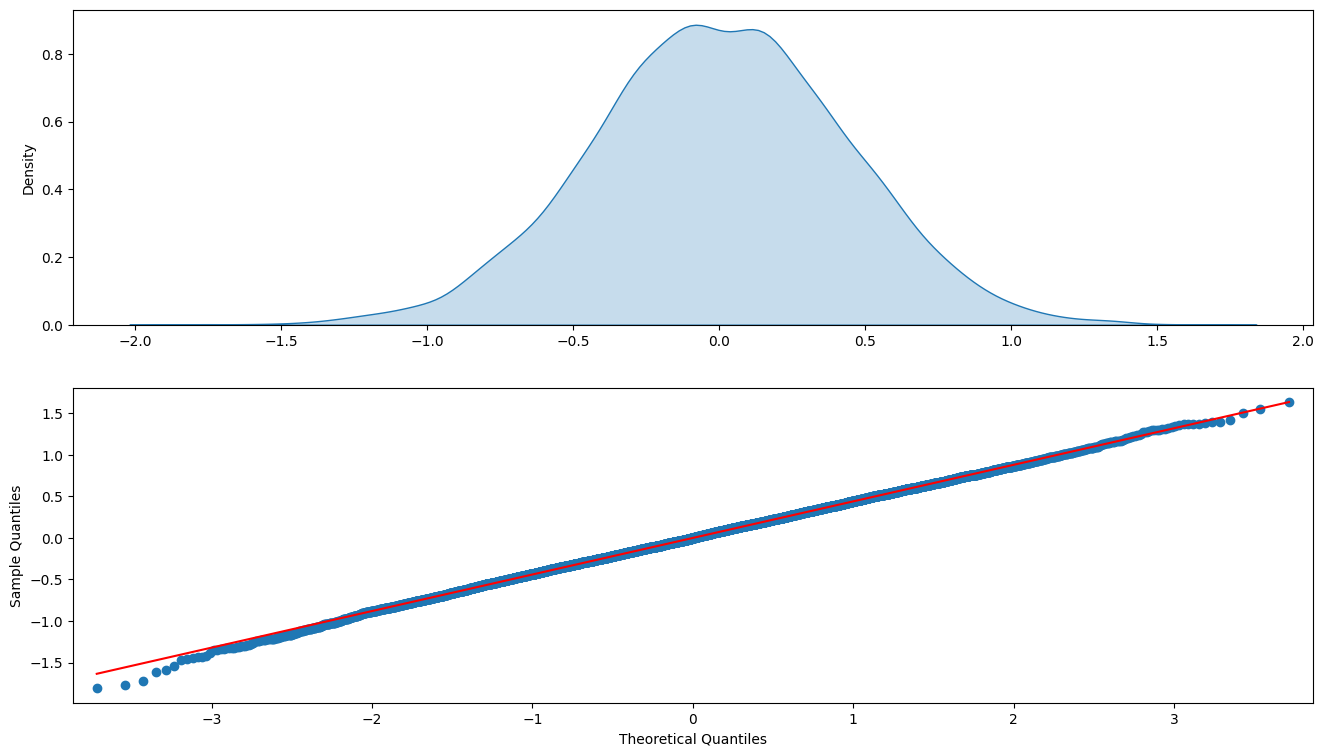

In [33]:
horizontal_break = Model("HORIZONTAL_BREAK ~ SPIN_RATE_ABSOLUTE + RELEASE_SPEED + RELEASE_SIDE + RELEASE_EXTENSION + HORIZONTAL_APPROACH_ANGLE + VERTICAL_APPROACH_ANGLE", data)
horizontal_break.scale_data(data.iloc[:,3:])
#horizontal_break.build_model("PITCHER_KEY")
horizontal_break.build_model("PITCHER_KEY","PITCH_TYPE_TRACKED_KEY")
print(horizontal_break.get_residuals())
horizontal_break.plot_resid()
prob_horizontal = horizontal_break.compute_prob()
display(prob_horizontal)

In [20]:
data['prob_affected'] = (prob_vertical['prob_affected'] + prob_horizontal['prob_affected'])/2
final_prob = data[['PID','prob_affected']]
final_prob